In [95]:
%matplotlib notebook
%autosave 0
#%matplotlib inline
import numpy as np
from numpy.random import RandomState
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import animation
#from os.path import join
import ipywidgets as widgets
from IPython.display import display
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torch import nn, cuda
from torch.autograd import Variable
import pickle
from torchsampler import ImbalancedDatasetSampler
#from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix, classification_report
from tqdm.notebook import tqdm

Autosave disabled


### Definiciones de Clases, Variables, Datasets

In [2]:
# original

class LightCurveRRL_Dataset(Dataset):
    def __init__(self, df_metadata, folder_name, transform=None):        
        self.data = list()
        self.name = df_metadata["ID_VVV"]
        self.period = df_metadata["OGLE_period"]
        self.label = torch.from_numpy(df_metadata["label"].values)
        self.transform = transform
        column_names_lc = ["mjd", "mag", "err"]
        column_names_fill = ["mjd", "mag", "err", "phase", "mask"]
        self.folder = folder_name
        #self.classes = ["T2C", "ECL"]
        df_zeros = pd.DataFrame(np.zeros((1, 5)),columns=column_names_fill)
                
        for i in range(len(df_metadata)):
            rrl_data = pd.read_csv(join(data_path, self.folder, self.name[i]+'.dat'), 
                                  header=None, delim_whitespace=True, comment='#', names=column_names_lc)
            #rrl_data.sort_values(by="mjd", inplace=True)
            rrl_data["phase"] = np.mod(rrl_data["mjd"], self.period[i])/self.period[i]
            #normalize
            mag_std = rrl_data["mag"].std()
            rrl_data["mjd"] = rrl_data["mjd"]-rrl_data["mjd"].min()
            rrl_data["mag"] = (rrl_data["mag"]-rrl_data["mag"].mean())/mag_std
            rrl_data["err"] = rrl_data["err"]/mag_std
            rrl_data.sort_values(by="phase", inplace=True)
            # ajustar todas a largo 335, rellenando con 0s las que sean mas pequeñas,
            # asignando un label '1' si es dato real y '0' si es dato rellenado.
            if len(rrl_data) == 335:
                rrl_data["mask"] = 1
            else:
                while len(rrl_data) < 335:
                    #RELLENAR con 0s;
                    rrl_data = rrl_data.append(df_zeros, ignore_index=True,sort=False)
            rrl_data = rrl_data.fillna(1)
            rrl_data = rrl_data[["phase","mag","err","mjd","mask"]]
            self.data.append(torch.from_numpy(rrl_data.values.astype('float32')))
            
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.label[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def plot(self, idx, ax):
        assert len(ax)==2, "Needs two subaxis"
        ax[0].cla()  
        ax[0].errorbar(self.data[idx][:, 0], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[0].invert_yaxis()
        ax[1].cla()
        ax[1].errorbar(self.data[idx][:, 3], self.data[idx][:, 1], self.data[idx][:, 2], fmt='.')
        ax[1].invert_yaxis()
        ax[0].set_title("%d %s %0.4f" %(idx, self.name[idx],self.period[idx]))

    def __len__(self):
        return len(self.data)

In [3]:
with open('PhaseSorted_NotInterp_ecl_c.pkl', 'rb') as handle:
    vvv_ecl_c = pickle.load(handle)
#label 0

In [4]:
with open('PhaseSorted_NotInterp_ecl_nc.pkl', 'rb') as handle:
    vvv_ecl_nc = pickle.load(handle)
#label 1

In [5]:
with open('PhaseSorted_NotInterp_ell.pkl', 'rb') as handle:
    vvv_ell = pickle.load(handle)
#label 2

In [6]:
with open('PhaseSorted_NotInterp_rrab.pkl', 'rb') as handle:
    vvv_rrab = pickle.load(handle)
#label 3

In [7]:
with open('PhaseSorted_NotInterp_rrc.pkl', 'rb') as handle:
    vvv_rrc = pickle.load(handle)
#label 4

In [8]:
VVV_b = [vvv_ecl_c,vvv_ecl_nc,vvv_ell,vvv_rrab,vvv_rrc]
VVV_len = [len(i) for i in VVV_b]
classes = ('ECL_Contact', 'ECL_No-Contact', 'Ellipsoid','RRL_AB', 'RRL_C')
#class_names = ['ECL_C','ECL_NC','ELL','RRAB','RRC']
#class_names = ['RRAB','RRC','ECL_C','ECL_NC','ELL']

In [9]:
def count_classes(datos):
    assert int(datos[0]['label'].item())==0
    classes=[[0,0],[1,0],[2,0],[3,0],[4,0]]
    for data in datos:
        label = int(data['label'].item())
        #print(label)
        if label == 0:
            classes[0][1]+=1
        elif label == 1:
            classes[1][1]+=1
        elif label == 2:
            classes[2][1]+=1
        elif label == 3:
            classes[3][1]+=1
        elif label == 4:
            classes[4][1]+=1
    return classes

**Dataset**

In [10]:
VVV = torch.utils.data.ConcatDataset([vvv_ecl_c, vvv_ecl_nc, vvv_ell,vvv_rrab, vvv_rrc])

In [ ]:
#phase = VVV[i]['data'][:,0]
#mag = VVV[i]['data'][:,1]
#err = VVV[i]['data'][:,2]
#mask = VVV[i]['data'][:,4]
#label = VVV[i]['label'].item()

In [ ]:
# pts100 son las curvas de luz con 100 o más puntos/entradas 'validas' (mascara mas larga = mayor # de 1s)
pts80 = list()
for i in VVV:
    mask=i['data'][:,4]
    if sum(mask)>=80:
        pts80.append(i)
print(len(pts80),count_classes(pts80))

In [ ]:
indice_menor = 5
cantidad_menor = min(VVV_len)
for i,a in enumerate(VVV_len):
    if a == cantidad_menor:
        indice_menor=i
print(indice_menor,cantidad_menor, cantidad_menor*5)

Generar Sampleo Random Manual Equitativo (EMRS)

In [11]:
def EMRS_dataset(rs):
    # Sampleo Random Manual NoEquitativo (NEMRS)
    VVV_toy = list()
    ant=0
    for i,a in enumerate(VVV_len):
        if i==2:
            randind = np.random.permutation(np.arange(a))[:789]+ant
        elif i==3:
            randind = np.random.permutation(np.arange(a))[:429*3]+ant
        elif i==4:
            randind = np.random.permutation(np.arange(a))[:429]+ant
        else:
            randind = np.random.permutation(np.arange(a))[:429*4]+ant
        VVV_toy.append(randind)
        ant=ant+a
    VVV_sameRandInd= np.concatenate(VVV_toy)
    # Data filter
    targets = [VVV[i]['label'].item() for i in VVV_sameRandInd]
    targets = torch.tensor(targets,dtype=torch.long)
    LC_magData = [VVV[i]['data'][:,1].numpy() for i in VVV_sameRandInd]
    LC_errData = [VVV[i]['data'][:,2].numpy() for i in VVV_sameRandInd]
    LC_mask = [VVV[i]['data'][:,4].numpy() for i in VVV_sameRandInd]
    LC_magData = torch.tensor(LC_magData)
    LC_errData = torch.tensor(LC_errData)
    LC_mask = torch.tensor(LC_mask)
    mag_err_mask=torch.stack((LC_magData,LC_errData,LC_mask),dim=1)
    # Dataset
    VVV_equalDataset = equal_manually_random(mag_err_mask, targets)
    return VVV_equalDataset

In [ ]:
VVV_eqData=EMRS_dataset(RandomState())


In [ ]:
VVV_toy = list()
ant=0
for i,a in enumerate(VVV_len):
    randind = np.random.permutation(np.arange(a))[:cantidad_menor]+ant
    VVV_toy.append(randind)
    ant=ant+a
VVV_sameRandInd= np.concatenate(VVV_toy)
VVV_sameRandInd

In [ ]:
targets = [VVV[i]['label'].item() for i in VVV_sameRandInd]
#targets = np.array(targets,dtype='float32')
targets = torch.tensor(targets,dtype=torch.long)
#targets = targets.unsqueeze(-1)
targets.shape

In [ ]:
LC_magData = [VVV[i]['data'][:,1].numpy() for i in VVV_sameRandInd]
LC_errData = [VVV[i]['data'][:,2].numpy() for i in VVV_sameRandInd]
LC_mask = [VVV[i]['data'][:,4].numpy() for i in VVV_sameRandInd]
LC_magData = torch.tensor(LC_magData)
LC_errData = torch.tensor(LC_errData)
LC_mask = torch.tensor(LC_mask)
#LC_magData = LC_magData.squeeze(-1)
LC_magData.shape

In [ ]:
mag_err_mask=torch.stack((LC_magData,LC_errData,LC_mask),dim=1)

In [12]:
class equal_manually_random(Dataset):    
    def __init__(self, data, targets,transform=None):
        assert torch.is_tensor(data)==True and torch.is_tensor(targets)==True
        self.data=data
        self.labels=targets
        self.transform=transform
    
    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'label': self.labels[idx]}
        if self.transform:
            sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.data)

In [ ]:
VVV_equalDataset = equal_manually_random(mag_err_mask, targets)

In [ ]:
VVV_equalDataset[:]['label']

### Dataloaders

In [13]:
def make_dataloaders(dataset,use_IDS,split,train_size=32,test_size=64):
    if use_IDS:
        # ImbalancedDatasetSampler
        train_idx, valid_idx= train_test_split(
                                        np.arange(len(dataset)),
                                        test_size=split,
                                        shuffle=True,
                                        stratify=dataset[:]['label'])
        train_idx, valid_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(dataset,
                          sampler=ImbalancedDatasetSampler(dataset,
                                                           indices=train_idx,
                                                           callback_get_label= lambda dataset, idx:dataset[idx]['label'].item()),
                          batch_size=train_size, shuffle=False)

        test_loader= DataLoader(dataset,
                                sampler=SubsetRandomSampler(valid_idx),
                                batch_size=test_size, shuffle=False)
    else:
        train_idx, valid_idx= train_test_split(
                                        np.arange(len(dataset)),
                                        test_size=split,
                                        shuffle=True,
                                        stratify=None)
        train_idx, valid_idx = list(train_idx), list(valid_idx)
        train_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(train_idx),
                                batch_size=train_size, shuffle=False)

        test_loader = DataLoader(dataset,
                                sampler=SubsetRandomSampler(valid_idx),
                                batch_size=test_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
train_loader, test_loader= make_dataloaders(VVV_equalDataset,0.25)

In [ ]:
#from sklearn.model_selection import train_test_split


train_idx, valid_idx= train_test_split(
                                    np.arange(len(VVV_equalDataset)),
                                    test_size=0.25,
                                    shuffle=True,
                                    stratify=None)
train_idx, valid_idx = list(train_idx), list(valid_idx)
display(len(train_idx), len(valid_idx))

In [ ]:
# probar SIN ImbalancedDatasetSampler

train_loader = DataLoader(VVV_equalDataset,
    sampler=SubsetRandomSampler(train_idx),
    batch_size=32, shuffle=False)

test_loader = DataLoader(VVV_equalDataset,
    sampler=SubsetRandomSampler(valid_idx),
    batch_size=64, shuffle=False)

### Def. Modelo NN

In [14]:
# implementacion adaptada a 1D de https://github.com/naoto0804/pytorch-inpainting-with-partial-conv

class PartialConv(nn.Module):
    def __init__(self, in_channels_C,in_channels_M, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv1d(in_channels_C, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv1d(in_channels_M, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        # self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self,input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)
        #print(input.shape, mask.shape)
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask

In [109]:
class MLP(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
        #                                 ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(10)
        
        self.hidden1 = torch.nn.Linear(c4*10, hid2_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid2_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        x = self.activation(x)
        #x = self.pool1(x)
        #mask = self.pool1(mask)
        x, mask = self.pconv2(x, mask)
        x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        #mask (batchx16x41)
        display("antes",x.shape)
        x=x[mask.bool()]
        display("despues",x.shape)
        """data_sliced=np.empty_like(x.cpu().detach().numpy())
        for i in range(len(x)):
            mask_tmp=mask[i,0].cpu().numpy().astype('int32')
            m= sum(mask_tmp)
            #print(m)
            wiri=x.cpu().detach()[i,:,:m]
            #print(wiri.shape)
            np.append(data_sliced,wiri)
        #display(data_sliced.shape,data_sliced)
        x=torch.from_numpy(data_sliced).cuda()
        """
        z = self.gap(x)
        #display(z)
        z = z.reshape(-1,16*10)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [108]:
class MLP_(torch.nn.Module):
    def __init__(self, in_channels_C=2,in_channels_M=1,c1=128,c2=64, c3=32, c4=16,c5=8, kernel_size=3, hid_dim=32,hid2_dim=16,hid3_dim=8,output_dim=5): 
        super(MLP_, self).__init__()
        self.pconv1 = PartialConv(in_channels_C,in_channels_M, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv2 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pconv3 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        #self.pconv4 = PartialConv(c4, c4, c4, kernel_size, stride=2, padding=0, dilation=1, bias=True)
        self.pool1 = torch.nn.AvgPool1d(kernel_size, stride=None, padding=0,
                                         ceil_mode=False, count_include_pad=True)
        self.gap = torch.nn.AdaptiveMaxPool1d(10)
        
        self.hidden1 = torch.nn.Linear(c4*10, hid2_dim, bias=True)
        self.hidden2 = torch.nn.Linear(hid2_dim, hid2_dim, bias=True)
        #self.hidden3 = torch.nn.Linear(hid2_dim, hid3_dim, bias=True)
        self.output = torch.nn.Linear(hid2_dim, output_dim, bias=True)

        self.activation = torch.nn.ReLU()
        #self.soft = torch.nn.Softmax(dim=1)
        
    def forward(self, x,mask, t=0):
        if t==1:
            x = x.transpose(0,1)
            mask = mask.transpose(0,1)
        elif t==2:
            #x = x.transpose(1,2)
            mask = mask.transpose(1,2)
    
        x, mask = self.pconv1(x, mask)
        #x = self.activation(x)
        #x = self.pool1(x)
        #mask = self.pool1(mask)
        x, mask = self.pconv2(x, mask)
        #x = self.activation(x)
        x, mask = self.pconv3(x, mask)
        #x = self.activation(x)
        #x, mask = self.pconv4(x, mask)
        z = self.gap(x)
        z = z.reshape(-1,16*10)
        z = self.activation(self.hidden1(z))
        z = self.activation(self.hidden2(z))
        #z = self.activation(self.hidden3(z))
        fuera = self.output(z)
        return fuera



In [ ]:
modelo = MLP()
display(modelo)

In [ ]:
total_params = sum(p.numel() for p in modelo.parameters() if p.requires_grad)
total_params

#### BetaTesting-b4-Train

In [ ]:
use_gpu = False
augmentation=5
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.0002)
for batch in train_loader:
    inputs, labels = batch['data'],batch['label']
    #print(inputs.shape,labels.shape)
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    #optimizer.zero_grad()
    r=np.random.randint(1,335)
    new_inputs = torch.cat((inputs[:,:,r:],inputs[:,:,jj:r]),dim=2)
    display(new_inputs.shape)
    #data = inputs[:].unsqueeze(-1)
    data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
    #display(mask[0].shape)
    data_aug,data_rot = data,data
    data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
   
    data_rot[:,0]=np.concatenate((data[:,0,r:],data[:,1,:r]),axis=0)
    data_rot[:,1]=np.concatenate((data[:,0,r:],data[:,1,:r]),axis=0)
    """for i,(d,m) in enumerate(zip(data,mask)):
        n=sum(m[:]==1).item()
        r=np.random.randint(n/2,n)
        #print(m.shape,n,r)
        mag,err,zeros=d[0,:n],d[1,:n],d[0,-(len(m)-n):]
        #display(335-n,zeros.shape)
        #mag,err y zeros son tensores
        #display(mag,err,zeros)
        new_mag = np.concatenate((mag[-r:],mag[:n-r],zeros),axis=0)
        new_err = np.concatenate((err[-r:],err[:n-r],zeros),axis=0)
        #display(n,r,mag,new_mag)
        #break
        data_rot[i,0]=torch.from_numpy(new_mag)
        data_rot[i,1]=torch.from_numpy(new_err)
        #display(data_rot[i,0],data_rot[i,1])"""
    data_aug_rot = data_rot
    data_aug_rot[:,0]=data_rot[:,0]+torch.randn_like(data_rot[:,0])*data_rot[:,1]
    break
    # ciclar phase entre [0,n/2] (n lineas reales sin mascara)
    #display(data.shape,mask[:,:])
    #display(mask.transpose(1,2).shape)
"""
for batch in train_loader:
    inputs, labels = batch['data'],batch['label']
    y_true=labels.numpy()
    if use_gpu:
        inputs, labels = inputs.cuda(), labels.cuda()
    data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
    #display(data.shape,mask.shape)
    #data augmentation
    data_aug = data
    for i in range(augmentation):
        if i!=0:
            data_aug[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]
        #data_aug=data_aug.cuda()
        optimizer.zero_grad()
        outputs = modelo.forward(data_aug,mask,t=2)
        # Accuracy
        y_pred=outputs.detach().argmax(dim=1).numpy()
        acc= sum(y_pred==y_true)/len(y_pred)*100
        print(acc)
        loss = criterion(outputs,labels)
        #display(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()"""
    
    #outputs=modelo.forward(data_aug,mask,t=2)
    #print(outputs.shape,labels.shape)
    #loss=criterion(outputs,labels)
    #print(loss.item())
    #break

**Check GPU**

In [53]:
torch.cuda.current_device()

2

In [52]:
torch.cuda.set_device('cuda:2')

**Training Params**

In [ ]:
n_epochs=1000
epochs = range(n_epochs)
use_gpu = True
aug_alpha = 1
rot_key = False
best_valid = np.inf
train_loss, valid_loss = 0.0, 0.0
TL,VL,F1=list(),list(),list()
ultima_mejora = 0
#running_loss = np.zeros(shape=(n_epochs, 2))
#augmentation = 4

if use_gpu:
    modelo = modelo.cuda()

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.0002)

In [ ]:
comentario = "pConv_mag&err_dataAugAlpha"+str(aug_alpha)+"_dataRot"+str(rot_key)+"_equalDataset"+str(VVV_equalDataset.__len__())+"_notInterpol_LR2e4_params"+str(total_params)
path = '/home/amorales/models/best_LC_model_'+comentario+'.pt'

**Training**

In [ ]:
train_loader.__len__()

In [ ]:
print("empezamos...")
#from tqdm.notebook import tqdm
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=False)

for k in tqdm(epochs):
    if k-ultima_mejora >=200:
        print("Hace al menos 200 épocas NO estoy generalizando correctamente :/ \n fix me!")
        break
    train_loss, valid_loss,f1_acum = 0.0, 0.0, 0.0
    # Loop de entrenamiento
    for batch in train_loader:
        inputs, labels = batch['data'],batch['label']
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
        #data augmentation
        if rot_key:
            r=np.random.randint(5,100)
            inputs = torch.cat((inputs[:,:,r:],inputs[:,:,:r]),dim=2)
        data[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]*aug_alpha  
        
        optimizer.zero_grad()
        outputs = modelo.forward(data,mask,t=2)
        loss = criterion(outputs,labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    TL.append(train_loss/train_loader.__len__()) 
    
    # VALIDACION 
    for data in test_loader:
        sample_data, sample_label = data['data'],data['label']
        #sample_label = sample_label.squeeze(1)
        y_true=sample_label.numpy()

        if use_gpu:
            sample_data, sample_label = sample_data.cuda(), sample_label.cuda()
        data,mask = sample_data[:,:2],sample_data[:,2].unsqueeze(-1)
        #display(data.shape, a.shape)
        outputs = modelo.forward(data,mask,t=2)
        # F1 score
        y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
        f1_acum += f1_score(y_true, y_pred, average='weighted')
        loss = criterion(outputs,sample_label)
        valid_loss += loss.item()
        # save best model
    if valid_loss < best_valid:
        ultima_mejora = k+1
        print("vamos mejorando :) epoch=",k+1)
        best_valid = valid_loss
        torch.save({'epoca': k,
                    'f1_score': f1_acum/test_loader.__len__(),
                    'model_state_dict': modelo.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'Valid_loss': valid_loss/test_loader.__len__()}, path)
    VL.append(valid_loss/test_loader.__len__())
    F1.append(f1_acum/test_loader.__len__())
    update_plot(ax,TL,VL,F1)

       
# Retornar modelo a la CPU
if use_gpu:
    modelo = modelo.cpu()
    print("fin")

### Eval. Desempeño

In [ ]:
def update_plot(ax,TL,VL,F1):
    #global modelo 
    [ax_.cla() for ax_ in ax]
    ax[0].plot(range(len(TL)), TL, lw=2, label='Train')
    ax[0].plot(range(len(VL)), VL, lw=2, label='Valid')
    ax[1].plot(range(len(F1)), F1, lw=2, label='F1 score')
    [ax_.grid() for ax_ in ax]
    [ax_.legend() for ax_ in ax]
    fig.canvas.draw()
    fig.canvas.flush_events()

In [ ]:
display(min(TL), min(VL), F1[ultima_mejora])

**Matriz de Confusion**

In [ ]:
besto = MLP()
PATH = '/home/amorales/models/best_LCC_model_dataRot0_Alpha1_sampleo4.pt'
besto.load_state_dict(torch.load(PATH)['model_state_dict'])

In [ ]:
# MODIFICAR
#y_true = [best_of_best[i]['label'].item() for i in range(len(best_of_best))]
#y_true = [VVV[i]['label'].item() for i in valid_idx]

prediction_test = []
labels_test=[]
for data in test_loader:
    inputs, labels = data['data'],data['label']
    data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
    labels_test.append(labels.detach().numpy())
    outputs = besto.forward(data,mask,t=2)
    #logits = modelo.forward(sample_data)
    #print(outputs)
    prediction_test.append(outputs.detach().argmax(dim=1).numpy())
y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)
print(y_pred.__len__()/5)
cm = confusion_matrix(y_true, y_pred)
display(cm)

print(classification_report(y_true, y_pred))

### Comparación entre distintos Modelos
Historial Matrices de Confusion [https://docs.google.com/spreadsheets/d/1j9kseGSx1WQvkb1C4nDL5J-lweuH3VyPsrAT50E1D6w/edit#gid=0]

In [36]:
def training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, test_loader,path,ax,topf1_logs):
    optimizer = torch.optim.Adam(modelo.parameters(), lr=lr,weight_decay=wd)
    ultima_mejora = 0
    best_valid,best_f1= np.inf,0.0
    TL,VL,F1=list(),list(),list()

    for k in tqdm(epochs):
        if k-ultima_mejora >=300:
            print("Hace al menos 300 épocas NO disminuye Valid Loss. Best F1=",best_f1)
            break
        train_loss, valid_loss,f1_acum = 0.0, 0.0, 0.0
        # Loop de entrenamiento
        for batch in train_loader:
            inputs, labels = batch['data'],batch['label']
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()
            data,mask = inputs[:,:2],inputs[:,2].unsqueeze(-1)
            #data augmentation
            if rot_key:
                r=np.random.randint(5,100)
                inputs = torch.cat((inputs[:,:,r:],inputs[:,:,:r]),dim=2)
            data[:,0]=data[:,0]+torch.randn_like(data[:,0])*data[:,1]*alpha  

            optimizer.zero_grad()
            outputs = modelo.forward(data,mask,t=2)
            loss = criterion(outputs,labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        TL.append(train_loss/train_loader.__len__()) 

        # VALIDACION 
        for data in test_loader:
            sample_data, sample_label = data['data'],data['label']
            #sample_label = sample_label.squeeze(1)
            y_true=sample_label.numpy()

            if use_gpu:
                sample_data, sample_label = sample_data.cuda(), sample_label.cuda()
            data,mask = sample_data[:,:2],sample_data[:,2].unsqueeze(-1)
            #display(data.shape, a.shape)
            outputs = modelo.forward(data,mask,t=2)
            #print(outputs.cpu().detach().argmax(dim=1).numpy())
            # F1 score
            y_pred=outputs.cpu().detach().argmax(dim=1).numpy()
            f1_acum += f1_score(y_true, y_pred, average='weighted')
            loss = criterion(outputs,sample_label)
            #print(loss.item())
            valid_loss += loss.item()
            #print(valid_loss)
            # save best model
        if valid_loss < best_valid:
            ultima_mejora = k+1
            #print("vamos mejorando :) epoch=",k+1)
            best_valid = valid_loss
            best_f1 = f1_acum/test_loader.__len__()
            torch.save({'epoca': k,
                        'f1_score': best_f1,
                        'model_state_dict': modelo.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'Valid_loss': valid_loss/test_loader.__len__()}, path)
        VL.append(valid_loss/test_loader.__len__())
        F1.append(f1_acum/test_loader.__len__())
        update_plot(ax,TL,VL,F1,ultima_mejora,best_f1,topf1_logs)

    # Retornar modelo a la CPU
    if use_gpu:
        modelo = modelo.cpu()
        #print("ok")
    return best_f1

In [37]:
def update_plot(ax,TL,VL,F1,last_ep,best_f1,topf1_logs):
    #global comentario
    titulo="Current Training. Rot="+str(bool(rot_key))+", Alpha="+str(alpha)+", Sample="+str(s)
    [ax_.cla() for ax_ in ax]
    ax[0].plot(range(len(TL)), TL, lw=2, label='Train')
    ax[0].plot(range(len(VL)), VL, lw=2, label='Valid')
    #ax[0].axvline(last_ep,c='r',marker='|',lw=1,label="Last improve")
    ax[0].plot(range(len(VL)),np.full_like(VL,min(VL)),'r--',lw=1, label='best VL')
    ax[1].plot(range(len(F1)), F1, lw=2, label='F1 score')
    if len(topf1_logs)==0:
        # plot topf1 actual
        ax[1].plot(range(len(F1)),np.full_like(F1,best_f1),'r--',lw=1, label='top F1')
        
    else:
        # plot topf1 mean
        ax[1].plot(range(len(F1)),np.full_like(F1,best_f1),'g--',lw=1, label='top F1')
        ax[1].plot(range(len(F1)),np.full_like(F1,np.mean(topf1_logs)),'r--',lw=1, label='mean F1')
    [ax_.set_xlabel('Epochs') for ax_ in ax]
    [ax_.grid() for ax_ in ax]
    [ax_.legend() for ax_ in ax]
    fig.suptitle(titulo)
    fig.canvas.draw()
    fig.canvas.flush_events()

In [38]:
# Parametros generales
n_epochs=10
lr=0.0002
wd = 0
epochs = range(n_epochs)
use_gpu = True
use_IDS = True
criterion = torch.nn.CrossEntropyLoss()
semilla=420
rs=RandomState(semilla)
split,train_size,test_size=0.25,32,64

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=True, sharex=True)
# for IDS in [0,1]:
for rot_key in [0,1]:
    for alpha in [0,0.25,0.5,0.75,1]:
        top5f1=list()
        prompt="Training. Rot="+str(rot_key)+", Alpha="+str(alpha)
        print("\nBegin",prompt)
        for s in range(3): 
            comentario = "_Rot"+str(rot_key)+"_Alpha"+str(alpha)+"_sampleo"+str(s)
            path = '/home/amorales/models/best_LCC_model_fixAdapMaxPool_'+comentario+'.pt'
            # sampleo random manual y crear dataset
            VVV_eqData=EMRS_dataset(rs)
            # DataLoaders
            # TOGGLE IDS
            train_loader, test_loader = make_dataloaders(VVV_eqData,use_IDS,split,train_size,test_size)
            # ENTRENAR
            modelo=MLP()
            if use_gpu:
                modelo=modelo.cuda()
            topf1 = training(modelo, criterion, lr,wd, epochs, use_gpu, train_loader, test_loader,path,ax,top5f1)
            top5f1.append(topf1)
        
        # return f1 mean, f1 std
        print("Results: F1 mean=",np.mean(top5f1),"F1 std=",np.std(top5f1))
        print("End",prompt)
print("-------END-------")

<IPython.core.display.Javascript object>


Begin Training. Rot=0, Alpha=0


'antes'

torch.Size([32, 16, 41])

'despues'

torch.Size([7088])

RuntimeError: Expected 3-dimensional tensor, but got 1-dimensional tensor for argument #1 'self' (while checking arguments for adaptive_max_pool1d)

In [43]:
with open('lc_debug.pkl', 'rb') as handle:
    lc_debug = pickle.load(handle)

In [47]:
path1= '/home/amorales/models/best_LCC_model_NoPool__Rot1_Alpha1_sampleo1.pt'
path0= '/home/amorales/models/best_LCC_model__Rot1_Alpha1_sampleo0.pt'

In [48]:
besto0,besto1 = MLP_(),MLP()
#PATH = '/home/amorales/models/best_LCC_model_dataRot0_Alpha1_sampleo4.pt'
besto0.load_state_dict(torch.load(path0)['model_state_dict'])
besto1.load_state_dict(torch.load(path1)['model_state_dict'])

<All keys matched successfully>

<IPython.core.display.Javascript object>


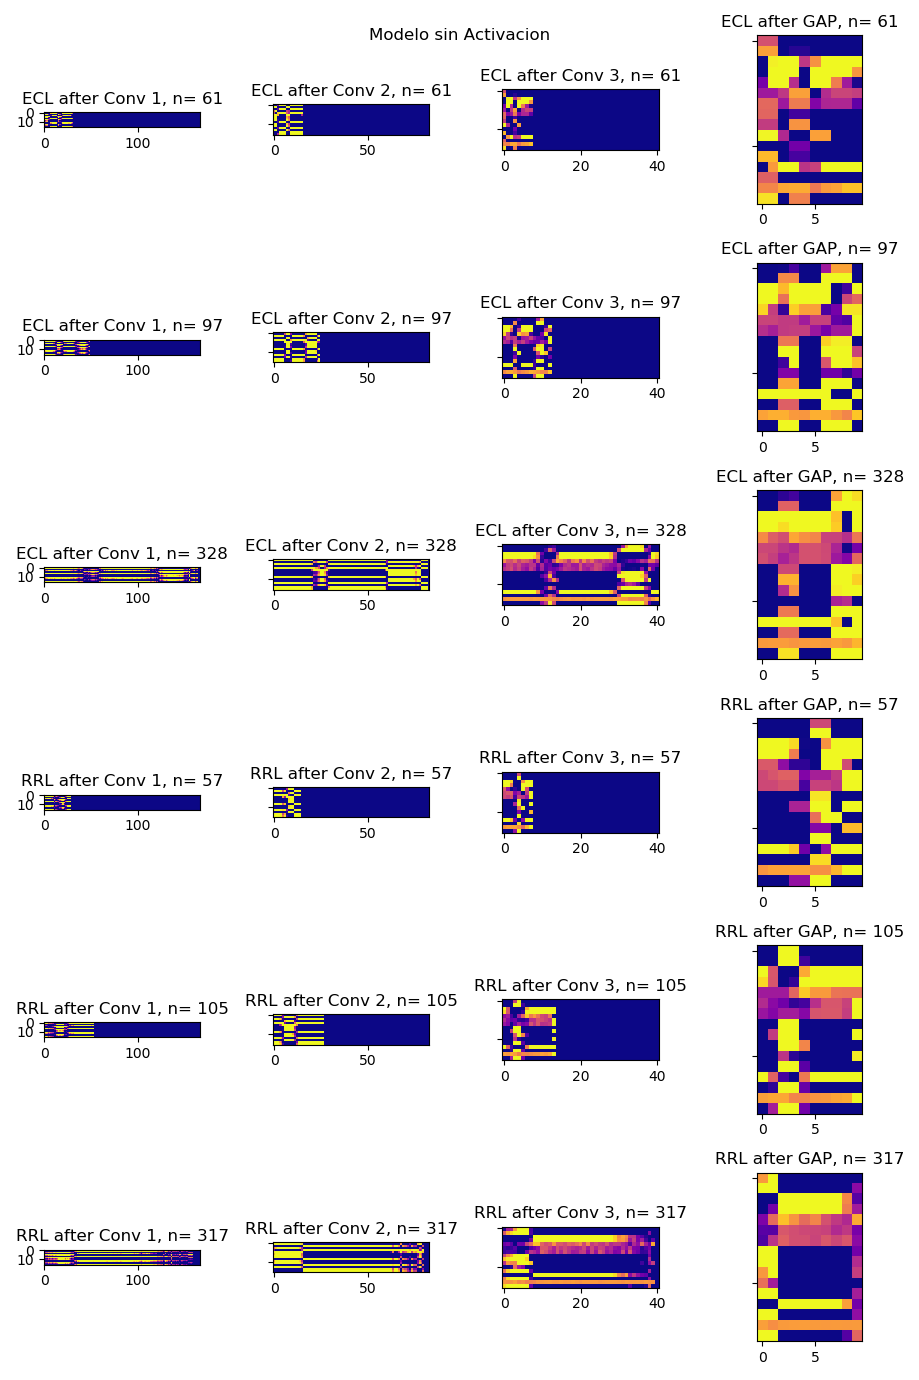

<IPython.core.display.Javascript object>


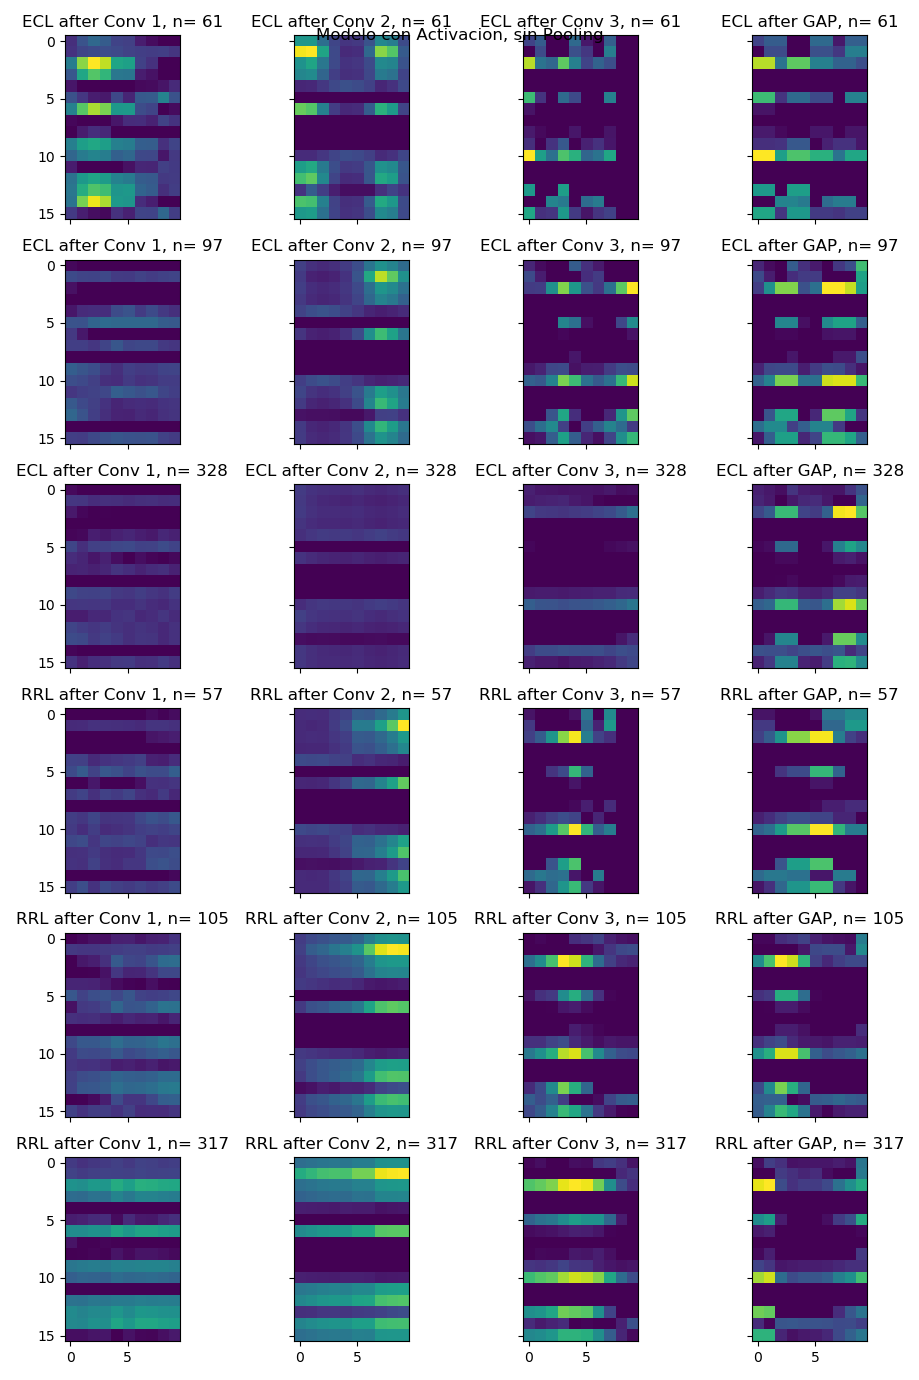

61
8 8


torch.Size([1, 16, 10])

torch.Size([1, 16, 10])

97
13 13


torch.Size([1, 16, 10])

torch.Size([1, 16, 10])

328
41 41


torch.Size([1, 16, 10])

torch.Size([1, 16, 10])

57
8 8


torch.Size([1, 16, 10])

torch.Size([1, 16, 10])

105
14 14


torch.Size([1, 16, 10])

torch.Size([1, 16, 10])

317
40 40


torch.Size([1, 16, 10])

torch.Size([1, 16, 10])

In [107]:
pond=2.3
fig1, ax1 = plt.subplots(6, 4, figsize=(4*pond, 6*pond), tight_layout=True,sharey=True,sharex=False)
fig2, ax2 = plt.subplots(6, 4, figsize=(4*pond, 6*pond), tight_layout=True,sharey=True,sharex=True)
fig1.suptitle("Modelo sin Activacion")
fig2.suptitle("Modelo con Activacion, sin Pooling")
for i,lc in enumerate(lc_debug):
    data,label=lc['data'],lc['label']
    n = sum(data[:,4]==1).item()
    print(n)
    pha = data[:,0]
    mag = data[:,1]
    err = data[:,2]
    data2=torch.stack((mag,err))
    data,mask = data2.unsqueeze(0),data[:,4].unsqueeze(-1).unsqueeze(0).transpose(1,2)
    #data,mask = data[:,:2].unsqueeze(0).transpose(1,2),data[:,4].unsqueeze(0).unsqueeze(-1).transpose(1,2)
    norm = Normalize(0,1,clip=False)
    for j in range(4):
        if i<3:
            star="ECL"
        else:
            star="RRL"
        if j!=3:
            layer="Conv "+str(j+1)
        else:
            layer="GAP"
        if j==0:
            data0,mask0=besto0.pconv1(data,mask)
            data1,mask1=besto1.pconv1(data,mask)
            data1=besto1.activation(data1)

        elif j==1:
            data0,mask0=besto0.pconv2(data0,mask0)
            data1,mask1=besto1.pconv2(data1,mask1)
            data1=besto1.activation(data1)

        elif j==2:
            data0,mask0=besto0.pconv3(data0,mask0)
            data1,mask1=besto1.pconv3(data1,mask1)
            data1=besto1.activation(data1)

        else:       
            mask0_tmp=mask0.squeeze()[0].numpy().astype('int32')
            mask1_tmp=mask1.squeeze()[0].numpy().astype('int32')
            m0,m1= sum(mask0_tmp),sum(mask1_tmp)
            print(m0,m1)
            data0_tmp=data0.squeeze().detach()
            data1_tmp=data1.squeeze().detach()
            data0_slice=data0_tmp[:,:m0].unsqueeze(0)
            data1_slice=data1_tmp[:,:m1].unsqueeze(0)
            """mask0_tmp=mask0.bool()
            data0_slice=data0[mask0_tmp]
            mask1_tmp=mask1.bool()
            data1_slice=data1[mask1_tmp]
            display(mask1_tmp.shape,data1_slice.shape)"""
            data0=besto0.gap(data0_slice)
            data1=besto1.gap(data1_slice)
            display(data0.shape,data1.shape)
        #plot
        #ax1[i][j].errorbar(pha,mag,err, fmt='b.')
        #ax2[i][j].errorbar(pha,mag,err, fmt='b.')
        filtro0=data0.squeeze().detach().numpy()
        filtro1=data1.squeeze().detach().numpy()
        ax1[i][j].imshow(filtro0,norm=norm,cmap='plasma')
        ax2[i][j].imshow(filtro1,norm=None)
        ax1[i][j].set_title(star+" after "+layer+", n= "+str(n))
        ax2[i][j].set_title(star+" after "+layer+", n= "+str(n))
        if i==0 and j==0:
            ax1[i][j].invert_yaxis()
            ax2[i][j].invert_yaxis()

        

In [ ]:
torch.repeat_interleave?

In [80]:
x = torch.tensor([[1,2,3],[4,5,6]])
y = torch.from_numpy(np.random.random(100))
y_rp = y.repeat_interleave(2,dim=0)
display(y,y_rp,y.shape,y_rp.shape)

tensor([0.1690, 0.1648, 0.2411, 0.6945, 0.3269, 0.8148, 0.6990, 0.0977, 0.0186,
        0.5397, 0.0545, 0.6475, 0.3553, 0.8530, 0.3039, 0.9238, 0.2594, 0.6825,
        0.8872, 0.4226, 0.9044, 0.2263, 0.6034, 0.5522, 0.4315, 0.6319, 0.0758,
        0.3574, 0.8723, 0.8300, 0.0652, 0.6157, 0.4714, 0.7394, 0.2581, 0.5692,
        0.6813, 0.1739, 0.6508, 0.2343, 0.1218, 0.8889, 0.7568, 0.4714, 0.9604,
        0.8704, 0.3895, 0.5243, 0.7140, 0.4259, 0.0833, 0.7720, 0.5494, 0.9328,
        0.2644, 0.4430, 0.5342, 0.0039, 0.8143, 0.7337, 0.4865, 0.7636, 0.0186,
        0.7432, 0.1702, 0.3255, 0.5001, 0.0992, 0.9431, 0.1118, 0.3120, 0.6808,
        0.5649, 0.7395, 0.0954, 0.9275, 0.7707, 0.6694, 0.0755, 0.4781, 0.8138,
        0.6979, 0.2745, 0.9862, 0.4579, 0.0850, 0.0589, 0.0527, 0.4868, 0.1926,
        0.1094, 0.4332, 0.6700, 0.2377, 0.0614, 0.8750, 0.0424, 0.1732, 0.8791,
        0.7711], dtype=torch.float64)

tensor([0.1690, 0.1690, 0.1648, 0.1648, 0.2411, 0.2411, 0.6945, 0.6945, 0.3269,
        0.3269, 0.8148, 0.8148, 0.6990, 0.6990, 0.0977, 0.0977, 0.0186, 0.0186,
        0.5397, 0.5397, 0.0545, 0.0545, 0.6475, 0.6475, 0.3553, 0.3553, 0.8530,
        0.8530, 0.3039, 0.3039, 0.9238, 0.9238, 0.2594, 0.2594, 0.6825, 0.6825,
        0.8872, 0.8872, 0.4226, 0.4226, 0.9044, 0.9044, 0.2263, 0.2263, 0.6034,
        0.6034, 0.5522, 0.5522, 0.4315, 0.4315, 0.6319, 0.6319, 0.0758, 0.0758,
        0.3574, 0.3574, 0.8723, 0.8723, 0.8300, 0.8300, 0.0652, 0.0652, 0.6157,
        0.6157, 0.4714, 0.4714, 0.7394, 0.7394, 0.2581, 0.2581, 0.5692, 0.5692,
        0.6813, 0.6813, 0.1739, 0.1739, 0.6508, 0.6508, 0.2343, 0.2343, 0.1218,
        0.1218, 0.8889, 0.8889, 0.7568, 0.7568, 0.4714, 0.4714, 0.9604, 0.9604,
        0.8704, 0.8704, 0.3895, 0.3895, 0.5243, 0.5243, 0.7140, 0.7140, 0.4259,
        0.4259, 0.0833, 0.0833, 0.7720, 0.7720, 0.5494, 0.5494, 0.9328, 0.9328,
        0.2644, 0.2644, 0.4430, 0.4430, 

torch.Size([100])

torch.Size([200])

In [ ]:
pond=2
#fig, ax = plt.subplots(4, 2, figsize=(4*pond, 6*pond), tight_layout=False)
fig, ax = plt.subplots(1, 2, figsize=(8.5, 4), tight_layout=True, sharex=False)
data=lc_debug[1]['data']
n = sum(data[:,4]==1).item()
print(n)
mag = data[:,1]
err = data[:,2]
data2=torch.stack((mag,err))
data,mask = data2.unsqueeze(0),data[:,4].unsqueeze(-1).unsqueeze(0).transpose(1,2)
data1,mask1=besto0.pconv1(data,mask)
mask_tmp=mask1.squeeze()[0].numpy().astype('int32')
m= sum(mask_tmp)
print(m)
data_tmp=data1.squeeze().detach()
data_slice=data_tmp[:,:m]
data_repeat=data_slice.repeat_interleave(2,dim=1)[:,:-1]
display(data_repeat.shape,data_slice.shape)
ax[0].imshow(data_repeat)
ax[1].imshow(data_slice)